# Niklas Abraham | Physics Waves-Simulation | Version 3

## 1. Introduction

This is a notebook with the goal of being able to create waves simulations. Is should be able to make single time $s/t$ and place $s/x$ diagrams as well as a small animation be no longer than $T$, the period duration.

The idea behind this code is to build one simualtion class "simualtion". This class will then manage object from the class "waves", which controls all the wave spefic calculations. The resulting wave is then combined in the "simualtion" class. This is done out of the sample points provided by the wave class in a numpy array. The sampple size $n$ is changeable.

The waves have their own function $s(x,t) = \hat{s} * sin(2\pi*(\frac{t}{T}-\frac{x}{\lambda}))$.

## 2. Code

Starting with all the import and then the basic settings.

In [1]:
import os
import re
import cv2
import math
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks                                          
from scipy.interpolate import interp1d

It starts with inline to avoid wired outputs later in the video production.

In [2]:
%matplotlib inline

The class wave is supposed to control one wave. The input parameters are $pos_x$ and decide where the wave is starting. The $s_hat$ simply defines the max amplitude, $T$ is the perodic time, l is suposed to be lambda the wave length. 

In [3]:
class Wave:
    def __init__(self, pos_x, s_hat, T, l, n):
        self.pos_x = pos_x
        self.s_hat = s_hat
        self.T = T
        self.l = l
        self.n = n
        
    def get_value(self, x, t, fix_x=False):
        #print("values", (x.shape),(t.shape))
        if (abs(x) > (self.l/self.T) * t) and fix_x:
            return 0
        else:
            return self.s_hat * math.sin(2*math.pi* ( (t/self.T) - (x/self.l) ))
    
    def get_data(self, fix_value, range_cal, fix_x):
        if fix_x:
            data_n_points = np.linspace(range_cal[0], range_cal[1], num=self.n)
            fix_points = np.full((1, self.n), fix_value)[0]
            # print(data_n_points, fix_points, len(data_n_points), len(fix_points))
            # building up the new result array
            result = [self.get_value(fix_points[i], data_n_points[i], fix_x=fix_x) for i in range(0,self.n)]
            # returning resulting wave
            return np.array(result)
        else:
            data_n_points = np.linspace(range_cal[0], range_cal[1], num=self.n)
            fix_points = np.full((1, self.n), fix_value)[0]
            # print(data_n_points, fix_points, len(data_n_points), len(fix_points))
            if range_cal[0]<0:
                range_1 = [0,range_cal[0]*-1]
                range_2 = [0,range_cal[1]]
                
                points_1 = np.linspace(range_1[0], range_1[1], num=int(range_1[1]*self.n/(range_1[1]+range_2[1])))
                points_2 = np.linspace(range_2[0], range_2[1], num=int(range_2[1]*self.n/(range_1[1]+range_2[1])))
                
                array_1 = [self.get_value(points_1[i], fix_points[i], fix_x=True) for i in range(0,len(points_1))]
                array_2 = [self.get_value(points_2[i], fix_points[i], fix_x=True) for i in range(0,len(points_2))]

                result = np.concatenate([np.flip(np.array(array_1)),np.array(array_2)])
                return result
                
            else: 
                # building up the new result array
                result = [self.get_value(data_n_points[i], fix_points[i], fix_x=True) for i in range(0,self.n)]
            # returning resulting wave
            return np.array(result)

<IPython.core.display.Javascript object>


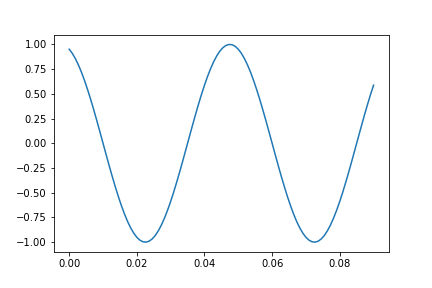

In [4]:
%matplotlib notebook
# testig the wave class
wave_test = Wave(0,1, 0.1, 0.05, 100)
#wave_test.get_value(5,0)
test = wave_test.get_data(0.32,[0,0.09],False)
#print(test)
plt.plot(np.linspace(0,0.09, num=100),test)
plt.show()

# test = wave_test.get_data(21,[-20,20],False)
# #print(test)
# plt.plot(np.linspace(-20,20, num=n),test)

The wave class work and is able to produce the right plots for any given place wth a given time. Moreover we are no able to plot a $s/t$ and $s/x$ diagram.
Next up is the simulation class. It will handle all the waves in an list and combine them.

In [5]:
a = np.array(range(10))
print(a)
print(np.roll(a, 2))

[0 1 2 3 4 5 6 7 8 9]
[8 9 0 1 2 3 4 5 6 7]


In [29]:
class Simulation:
    def __init__(self):
        self.waves = []
        self.resulting_wave = []
        self.flip = []
        self.newpath = ''
    
    def add_wave(self, wave, flip):
        self.waves.append(wave)
        self.flip.append(flip)
        
    def shift(self, xs, n):
        if n >= 0:
            return np.r_[np.full(n, 0), xs[:-n]]
        else:
            return np.r_[xs[-n:], np.full(-n, 0)]
        
    def cal_data(self, range_cal, fix_value, fix_x):
        waves_data = []
        # calculating all the data from the different waves
        for i in range(0,len(self.waves)):
            wave = self.waves[i]
            # data = wave.get_data(fix_value, [range_cal[0]-wave.pos_x, range_cal[1]-wave.pos_x], fix_x)
            data = wave.get_data(fix_value, [range_cal[0]-wave.pos_x, range_cal[1]-wave.pos_x], fix_x)
            if self.flip[i]:
                # data = np.flip(data)
                # data = np.roll(data, int(((wave.pos_x*n)/range_cal[1])+(fix_value*(wave.l/wave.T))*n/range_cal[1] ))
                # data = self.shift(data, 20)
                data = data
            waves_data.append(data)

        return waves_data
    
    def plot_images_range(self, range_cal, steps, time_range, x_data, folder=None):
        # this function is plotting the images in a special folder
        if (len(self.waves) < 1):
            print(' ------- No waves to simulate ------------')
            return None
        
        if not os.path.isdir('images'):
            os.makedirs('images')
        self.newpath = 'images/'+str(datetime.datetime.now().strftime("%d_%m_%Y__%H_%M_%S"))
        os.makedirs(self.newpath)
        
        steps_array = np.linspace(time_range[0],time_range[1], num = steps)

        for i in range(0, len(steps_array)):
            data = self.cal_data(range_cal, steps_array[i], False)

            fig, ax = plt.subplots()
            
            ax.set_xlim(range_cal[0], range_cal[1])
            max_a = max([r.s_hat for r in self.waves]) *2 + 2
            ax.set_ylim(-1*max_a, max_a)
            
            #ax.plot(x_data, data[0]+data[1], c='g', linewidth=3, alpha=1)
            ax.plot(x_data, data[0], c='b', linewidth=2, alpha=0.2)
            ax.plot(x_data, data[1], c='r', linewidth=2, alpha=0.2)
            fig.savefig(self.newpath+'/'+str(i)+'.png')
            plt.close()
            plt.clf()
            
    def plot_image(self, range_cal, time_p, x_data):
        # this function is plotting the waves at a time point
        if (len(self.waves) < 1):
            print(' ------- No waves to simulate ------------')
            return None

        data = self.cal_data(range_cal, time_p, False)
        # print(data[1], data[1].shape)
        fig, ax = plt.subplots()
        ax.set_xlim(range_cal[0], range_cal[1])
        max_a = max([r.s_hat for r in self.waves]) *2 + 2
        ax.set_ylim(-1*max_a, max_a)

        ax.plot(x_data, data[0]+data[1], c='g', linewidth=3, alpha=0.2)
        ax.plot(x_data, data[0], c='b', linewidth=2, alpha=0.8)
        ax.plot(x_data, data[1], c='r', linewidth=2, alpha=0.8)
        plt.show()
            
    def get_video(self, fps=10, path_output='viedo.avi', folder_images=None):
        # this function builds the video
        image_folder = self.newpath
        video_name = path_output
        images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
        images.sort(key=lambda f: int(re.sub('\D', '', f)))
        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, 0, fps, (width,height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()
        
    def get_s_t(self, place, time_range):
        # this function will plot the s t diagram for any given place
        result = []
        min_r = min([r.pos_x for r in self.waves])
        max_r = max([r.pos_x for r in self.waves])
        for t in time_range:
            data = self.cal_data([min_r,max_r], t, False)
            m = interp1d([min_r,max_r],[0,self.waves[0].n])
            u=int(m(place))
            result.append(data[0][u]+data[1][u])
        plt.plot(time_range, result)
        #plt.xlim(time_range[0], time_range[-1])
        #print(result)
        indices = find_peaks(result)[0]
        
        m = interp1d([0,len(time_range)], [time_range[0], time_range[-1]])
        x_d = [int(t) for t in m(indices)]
        
        plt.scatter(x_d, [result[e] for e in indices])
        
        plt.show()

Now we have a working wave and simulation class all of that works now and can be applied. First we set the basic parameters.

In [60]:
range_min = 0
range_max = 1
range_time = [1,2]
n = 400
steps = 300

# settings for f
s_f_hat = 1
T_f = 5
l_f = 1
# settings for g
s_g_hat = 1
T_g = 5
l_g = 1

<IPython.core.display.Javascript object>


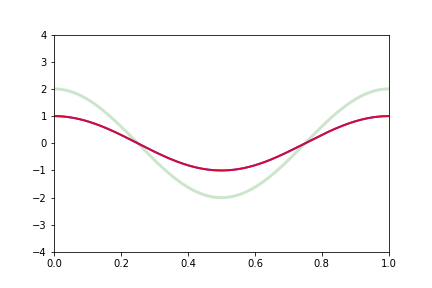

In [61]:
%matplotlib inline
%matplotlib notebook
sim = Simulation()

sim.add_wave(Wave(0,s_f_hat, T_f, l_f, n), False)
sim.add_wave(Wave(1,s_g_hat, T_g, l_g, n), True)

x_data = np.linspace(range_min,range_max, num = n)
sim.plot_image([range_min,range_max], 31.25, x_data)

# x_data = np.linspace(range_min,range_max, num = n)
# sim.plot_images_range([range_min, range_max], steps, range_time, x_data)
# sim.get_video(fps=10)

In [122]:
%matplotlib notebook

<IPython.core.display.Javascript object>


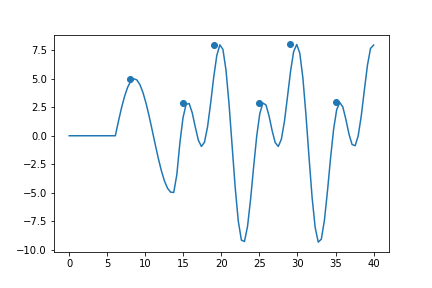

In [72]:
sim.get_s_t(6, np.linspace(0,40, num=100))